<a href="https://colab.research.google.com/github/Khuks/Predicting-stock-prices-using-LSTM-RNN-and-ARIMA/blob/main/Stock_price_forecasting_using_univariate_time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h3> I first impliment ARIMA model then implement LSTM Recurrent Neural Network later</h3>

In [51]:
#Here I installed some of the libraries that will be required 
!pip install nsepy
!pip install pmdarima

## 1. Import Libraries that will be used throughout the project

In [2]:
#Importing the libraries
import io
import math
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from pmdarima import auto_arima 
from datetime import datetime
import warnings 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

## 2. Data Preprocessing 

**2.1 Upload the .csv file from drive into colab**

In [3]:
#Uploading the .csv file from drive to colab 
from google.colab import files
dateCols=['datetime_col']
uploaded=files.upload()
data=pd.read_csv(io.BytesIO(uploaded['FSR.JO.csv']),parse_dates=True,index_col=0)
data

Saving FSR.JO.csv to FSR.JO (2).csv


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-11-16,1256.280029,1272.089966,1242.729980,1245.739990,622.662598,7297160
2005-11-17,1249.510010,1272.089966,1238.219971,1257.040039,628.310669,6868359
2005-11-18,1254.780029,1260.800049,1223.160034,1241.229980,620.408203,8445602
2005-11-21,1238.219971,1241.979980,1215.640015,1223.160034,611.376221,5446816
2005-11-22,1223.160034,1227.680054,1196.819946,1196.819946,598.210632,11775515
...,...,...,...,...,...,...
2020-11-09,4099.000000,4530.000000,4059.000000,4475.000000,4475.000000,34970498
2020-11-10,4430.000000,4655.000000,4326.000000,4644.000000,4644.000000,33208854
2020-11-11,4655.000000,5077.000000,4614.000000,4988.000000,4988.000000,59012627


In [4]:
#Get the number of rows and columns in the data set
data.shape

(3846, 6)

**2.2 Plot the closing price**

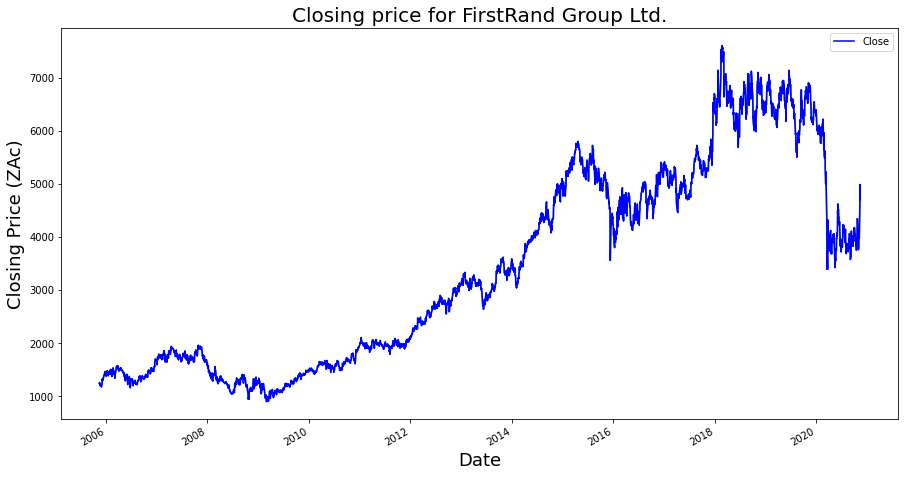

In [5]:
#Plotting the closing price as from  2005-11-16 to 2020-11-13
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price (ZAc)',fontsize=18)
plt.plot(data['Close'])
plt.title('Closing price for FirstRand Group Ltd.',fontsize=20)
data['Close'].plot(legend = True,color='b')
plt.show()

**2.3 Test for stationarity of the dataset**

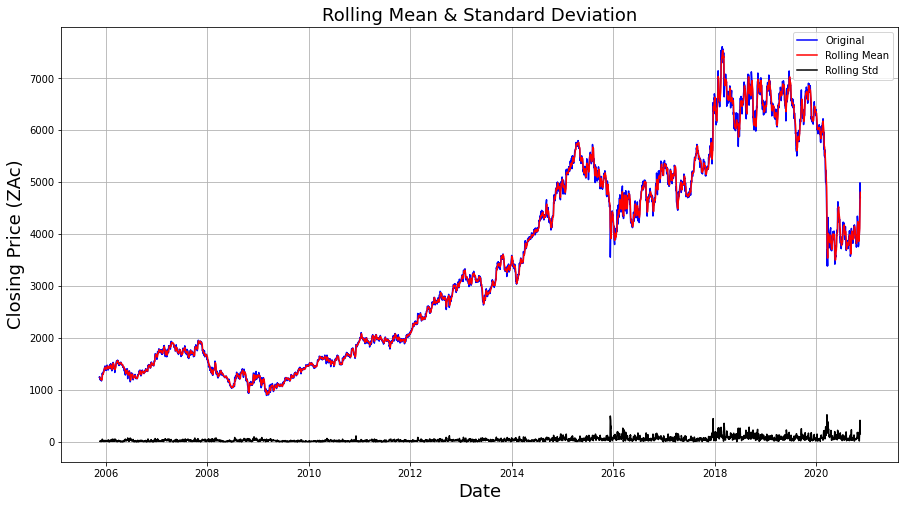

Results of Dickey-Fuller Test:
Test Statistic                   -1.162211
p-value                           0.689637
#Lags Used                       30.000000
Number of Observations Used    3815.000000
Critical Value (1%)              -3.432065
Critical Value (5%)              -2.862298
Critical Value (10%)             -2.567173
dtype: float64
result : time series data is not stationary since p>0.05


In [6]:
#Test for the stationarity of the dataset
#For testing stationarity we will use the augmented dickey fuller test
#Augmented Dickey Fuller test summarizes the result of : 
#       1. Test statstic:(is used in hypothesis test when you are deciding to support or
#          reject the null hypothesis)
#       2. p-value:(if the p-value obtained is greater than the significance level of 0.05,
#          then the data is not stationary)
#       3. critical value:(we use critical value to check if the value of the test statistic 
#          generated by the sample belongs to the "rejection region", or critical region)


#Check Stationarity - Dickey Fuller Test
def test_stationarity(timeseries):

  #Determine rolling statistics
  rolmean=timeseries.rolling(4).mean() #around 4 weeks on each month
  rolstd=timeseries.rolling(4).std()

  #Plot rolling statistics:
  orig=plt.plot(timeseries,color='blue',label='Original')
  mean=plt.plot(rolmean,color='red',label='Rolling Mean')
  std=plt.plot(rolstd,color='black',label='Rolling Std')
  plt.grid(True)
  plt.legend(loc='best')
  plt.xlabel('Date',fontsize='18')
  plt.ylabel('Closing Price (ZAc)',fontsize='18')
  plt.title('Rolling Mean & Standard Deviation',fontsize='18')
  plt.show(block=False)

  #Perform Dickey-Fuller test:
  print('Results of Dickey-Fuller Test:')
  dftest=adfuller(timeseries,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
   dfoutput['Critical Value (%s)' %key]=value
  print(dfoutput)

  if dfoutput['p-value']<0.05:
    print('result : time series data is  stationary since p<0.05')
  else : 
      print('result : time series data is not stationary since p>0.05')

from matplotlib.pylab import rcParams
#rcParams['figure.figsize']=20,10
plt.figure(figsize=(15,8))
test_stationarity(data['Close'])



**2.4 Visualize the trend,seasonality and the residue from the dataset**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

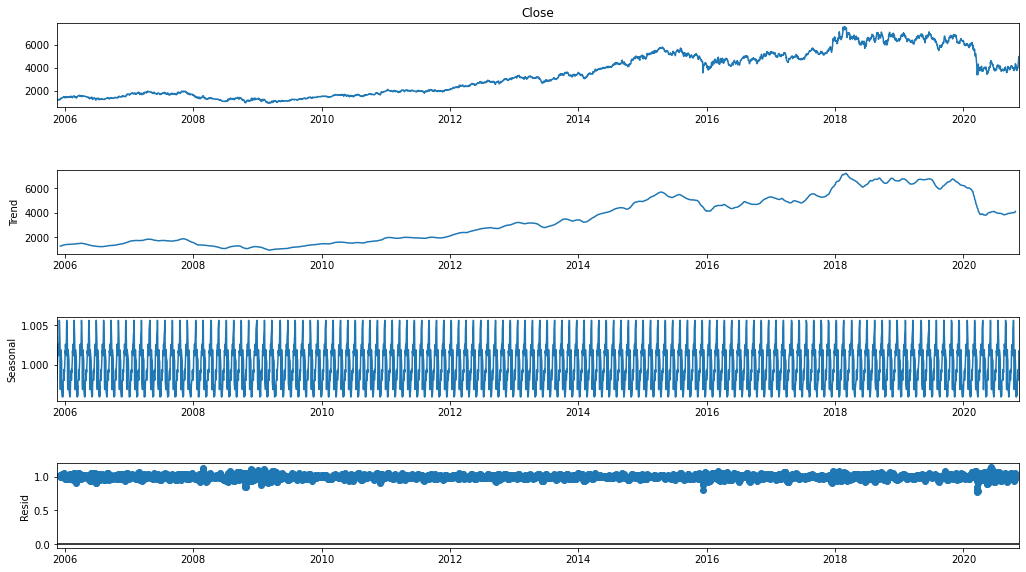

In [7]:
# In order to perform a time series analysis, we may need to separate seasonality and trend from our series.
# The resultant series will become stationary through this process.

result = seasonal_decompose(data['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

**2.5 Split the data into training and testing**

In [8]:
# Split data into train / test sets 
# Split the data into training and testing 
# For training : 80%
# For testing  : 20%

#train = data.iloc[:len(data)-300] 
#test = data.iloc[len(data)-300:]
train=data.iloc[:math.ceil(len(data)*0.8)]
test=data.iloc[math.ceil(len(data)*0.8):]

In [9]:
start = len(train) 
end = len(train) + len(test) - 1

<h1 align="center">ARIMA Model</h1>

## 3. Building and Fitting the model

**3.1 Fit auto arima to the closing price**

In [10]:
# Ignore harmless warnings
# We will fit the model using auto-arima:
#Auto ARIMA: 
#           The advantage of usimg Auto ARIMA over ARIMA model is that after data 
#            data preprocessing step we can skip the next steps & directly fit our model.
#            It uses the AIC(Akaike Informtion Criterion) & BIC(Bayesian Information Criterion)
#            values generated by trying different combinations of p,q & d values to fit the model

warnings.filterwarnings("ignore") 

# Fit auto_arima function to Stock Market Data
stepwise_fit = auto_arima(data['Close'], start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, d = None, D = 1, trace = True,
                          error_action ='ignore', suppress_warnings = True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=52865.525, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=45761.948, Time=7.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=49504.011, Time=8.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=52869.638, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=46691.583, Time=0.51 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=45295.935, Time=31.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=35.75 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=52815.617, Time=3.95 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=45297.100, Time=43.98 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=45297.053, Time=38.78 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=49503.926, Time=17.73 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=45287.771, Time=61.27 sec
 ARIMA(2,0,1)(1

**3.2 Print the summary of the model**

In [11]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3846
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood              -22636.885
Date:                             Mon, 02 Aug 2021   AIC                          45287.771
Time:                                     17:11:09   BIC                          45331.533
Sample:                                          0   HQIC                         45303.317
                                            - 3846                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2600      2.783      1.890      0.059      -0.194      10.714
ar.L1          0.0825      0.042      1.982      0.047       0.001       0.164
ar.L2          0.8170      0.040     20.349      0.000       0.738       0.896
ma.L1          0.8931      0.038     23.472      0.000       0.818       0.968
ar.S.L12      -0.6433      0.010    -62.278      0.000      -0.664      -0.623
ar.S.L24      -0.3497      0.010    -36.799      0.000      -0.368      -0.331
sigma2      7977.0530     93.209     85.583      0.000    7794.367    8159.739
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):              7004.94
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              12.47   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**2.3 Fit the model**

In [12]:
# Fit a SARIMAX (Seasonal ARIMA Model) because the time series data also conatins seasonality
model = SARIMAX(data['Close'],  order = (2, 0, 1),  seasonal_order =(2, 1, 0, 12)) 


In [13]:
#Fit the ARIMA model
# And also print the summary of the fitted model
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 3846
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood              -22643.016
Date:                             Mon, 02 Aug 2021   AIC                          45298.032
Time:                                     17:11:26   BIC                          45335.542
Sample:                                          0   HQIC                         45311.357
                                            - 3846                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7133      0.365      4.698      0.000       0.998       2.428
ar.L2         -0.7265      0.345     -2.107      0.035      -1.402      -0.051
ma.L1         -0.7601      0.369     -2.060      0.039      -1.483      -0.037
ar.S.L12      -0.6391      0.010    -64.958      0.000      -0.658      -0.620
ar.S.L24      -0.3441      0.009    -37.460      0.000      -0.362      -0.326
sigma2      7872.3075     90.413     87.070      0.000    7695.101    8049.514
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              6942.10
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              12.53   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. Predictions and Results

**4.1 Model predictions as from 2019-05-07 to 2020-11-13**

In [14]:
# Predictions for one-year against the test set 
predictions = result.predict(start, end, typ = 'levels').rename("Predictions")

In [17]:
#Display the predictions made  by the ARIMA model
predictions

Date
2017-10-23    5323.069202
2017-10-24    5298.547131
2017-10-25    5259.875873
2017-10-26    5230.013899
2017-10-27    5154.973298
                 ...     
2020-11-09    4039.240552
2020-11-10    4482.466735
2020-11-11    4523.661151
2020-11-12    4944.303898
2020-11-13    4788.778393
Name: Predictions, Length: 769, dtype: float64

**4.2 Plot the predictions and actual values of the closing price**

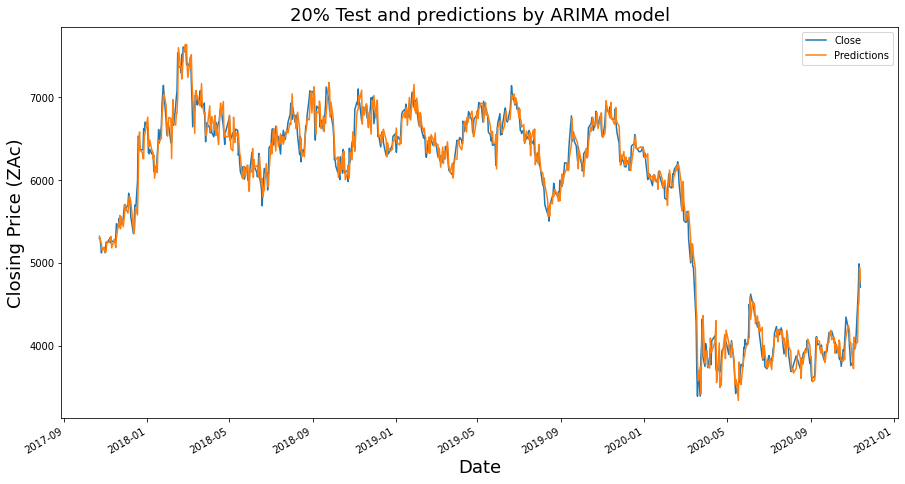

In [18]:
# plot predictions and actual values
plt.figure(figsize=(15,8)) 
plt.grid(True)
plt.title('20% Test and predictions by ARIMA model',fontsize='18')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price (ZAc)',fontsize=18)
test['Close'].plot(legend = True)
predictions.plot(legend = True) 

In [19]:
#We can print the predicted values alongside the original closing price 
d=data['Close']
training =d[:len(train)]
valid=d[len(train):]

[[valid,predictions]]


[[Date
  2017-10-23    5297.0
  2017-10-24    5298.0
  2017-10-25    5220.0
  2017-10-26    5120.0
  2017-10-27    5166.0
                 ...  
  2020-11-09    4475.0
  2020-11-10    4644.0
  2020-11-11    4988.0
  2020-11-12    4877.0
  2020-11-13    4707.0
  Name: Close, Length: 769, dtype: float64, Date
  2017-10-23    5323.069202
  2017-10-24    5298.547131
  2017-10-25    5259.875873
  2017-10-26    5230.013899
  2017-10-27    5154.973298
                   ...     
  2020-11-09    4039.240552
  2020-11-10    4482.466735
  2020-11-11    4523.661151
  2020-11-12    4944.303898
  2020-11-13    4788.778393
  Name: Predictions, Length: 769, dtype: float64]]

**4.3 Print out the metrics**

In [20]:
######RMSE#######
# RMSE for ARIMA model
err_ARIMA = rmse(test["Close"], predictions) 
print('RMSE for ARIMA ARIMA', err_ARIMA)

# report performance
#mse = mean_squared_error(test_data, fc)
#print('MSE: '+str(mse))
#mae = mean_absolute_error(test_data, fc)
#print('MAE: '+str(mae))
#rmse = math.sqrt(mean_squared_error(test_data, fc))
#print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test["Close"]-predictions)/(test["Close"]))*100
print('MAPE for ARIMA: '+str(mape)+' % ')

RMSE for ARIMA ARIMA 150.90118325361405
MAPE for ARIMA: 2.0647736329588753 % 


<h1 align="center">LSTM Recurrent Neural Network</h1>


## 2. Data Preprocessing for LSTM

**2.1 Split the data into training and testing**

In [34]:
#Create a new dataframe with only the 'Close' column
df=data.filter(['Close'])
#Convert the dataframe to a numpy array so that the values lie between 0 and 1
dataset=df.values

#Get the number of rows to train the model on
#We will use 80% of the dataset for training the model
training_data_len=math.ceil(len(dataset)*0.8) 

training_data_len

3077

**2.2 Scale the data using MinMaxScaler**

In [35]:
#Scale the data
#We scale the data to help the model recognise the values to be 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data =scaler.fit_transform(dataset)

scaled_data

array([[0.05199592],
       [0.05367994],
       [0.0513238 ],
       ...,
       [0.6096964 ],
       [0.59315432],
       [0.56781961]])

**2.3 Create the scaled training dataset**

In [36]:
#Craete the training data set
#First create the scaled training data set
train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])   #Print the values from index position 0 to 59
  y_train.append(train_data[i,0])        #Print the values indexed from position 60 
  if i<=60:
    print(x_train)
    print(y_train)
    print

[array([0.05199592, 0.05367994, 0.0513238 , 0.04863088, 0.04470548,
       0.0460512 , 0.04919272, 0.04638801, 0.04470548, 0.04616297,
       0.04358331, 0.04145221, 0.04526582, 0.04863088, 0.0559228 ,
       0.06377508, 0.05984967, 0.05984967, 0.0615322 , 0.06321473,
       0.0615322 , 0.06848733, 0.06848733, 0.07364667, 0.07387171,
       0.07678817, 0.07746029, 0.07947962, 0.07947962, 0.08452719,
       0.07947962, 0.07947962, 0.07330987, 0.07330987, 0.07891927,
       0.07667491, 0.07173911, 0.07858247, 0.07947962, 0.08116213,
       0.08677154, 0.08385507, 0.08475222, 0.07947962, 0.07330987,
       0.07274952, 0.0834065 , 0.08172248, 0.08049001, 0.08116213,
       0.08071356, 0.07723675, 0.07947962, 0.07779709, 0.0834065 ,
       0.08789223, 0.08890264, 0.08228431, 0.09058517, 0.08239608])]
[0.07611456210405976]


**2.4 Convert the x_trin and y_train to numpy array and reshape the data**

In [37]:
#Convert the x_train and y_train to numpy arrays
x_train,y_train = np.array(x_train),np.array(y_train)

In [38]:
#Reshape the x_train dataset
#We reshape the x_train data because LSTM expert the input to be three dimentional (3D)
#It should be in the form (number of samples,number of time steps,number of features)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1)) 
x_train.shape

(3017, 60, 1)

**2.5 Create the testing data set ,convert it to a numpy array and reshape it**

In [39]:
#Create the testing data set
#Create a new array containing scaled values from index 3017 to 3846

test_data= scaled_data[training_data_len-60:,:]

#Create the data sets x_test and y_test
x_test=[]
y_test= dataset[training_data_len:, :] #All, of the values we want our model to predict or the 61st values
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [40]:
#Convert x_test data to a numpy array
x_test =np.array(x_test)

In [41]:
#Reshape x_test data so that it can be fitted into an LSTM
# since LSTM take a 3D input data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

## 3. Build the LSTM Recurrent Model

**3.1 Build model**

In [31]:
#The input layer and the second layer have 50 neurons 
#The dense neural network layer which is the third layer has 25 neurons 
#The output layer which is a dense neuarl network has 1  output neuron 

#Defining the LSTM Recurrent Model
regressor = Sequential()

#Add the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))


#Add the second LSTM layer with some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = False))


#Add a fourth Dense layer 
regressor.add(Dense(units = 25))


#Adding the output layer
regressor.add(Dense(units = 1))



**3.2 Compile the LSTM model**

In [42]:
#Compeile the model
regressor.compile(optimizer='adam',loss='mean_squared_error')

**3.3 Train the LSTM model**

In [33]:
#Train the model
# The batch size being the number of samples being passed to the network at once
# An epoch refers to one cycle through the full training dataset
regressor.fit(x_train,y_train,batch_size=35,epochs=100)

Epoch 1/100
87/87 [==============================] - 22s 43ms/step - loss: 0.0156
Epoch 2/100
87/87 [==============================] - 4s 43ms/step - loss: 2.6598e-04
Epoch 3/100
87/87 [==============================] - 4s 44ms/step - loss: 2.3263e-04
Epoch 4/100
87/87 [==============================] - 4s 43ms/step - loss: 2.6236e-04
Epoch 5/100
87/87 [==============================] - 4s 43ms/step - loss: 2.1984e-04
Epoch 6/100
87/87 [==============================] - 4s 43ms/step - loss: 2.7843e-04
Epoch 7/100
87/87 [==============================] - 4s 43ms/step - loss: 2.5159e-04
Epoch 8/100
87/87 [==============================] - 4s 43ms/step - loss: 2.1739e-04
Epoch 9/100
87/87 [==============================] - 4s 44ms/step - loss: 2.3684e-04
Epoch 10/100
87/87 [==============================] - 4s 44ms/step - loss: 2.1820e-04
Epoch 11/100
87/87 [==============================] - 4s 43ms/step - loss: 2.1322e-04
Epoch 12/100
87/87 [==============================] - 4s 44ms/step

## 4. Predictions and Results of LSTM

**4.1 Get model's predicted values**

In [43]:
#Get the models predicted price values for x_test dataset
focast = regressor.predict(x_test)

#We perform inverse tranform because: 
#             We want predictions to contain the 
#             same value formarts as x_test
focast = scaler.inverse_transform(focast)



**4.2 Plot the 90% training dataset for LSTM**

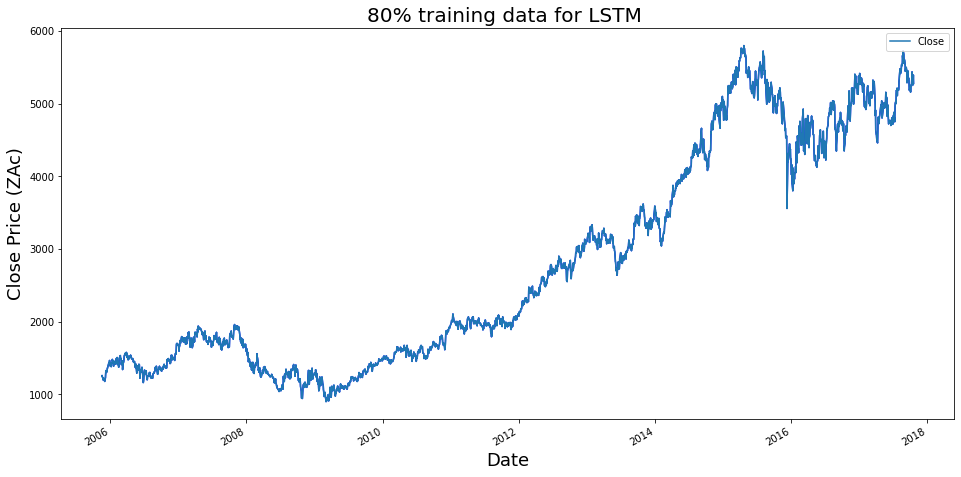

In [45]:
#Plot the training data set
train=df[:training_data_len]
valid=df[training_data_len:]
valid['Predictions']=focast

plt.figure(figsize=(16,8))
plt.grid(True)
plt.title('80% training data for LSTM ', fontsize=20)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (ZAc)',fontsize=18)
plt.plot(train['Close'],color='b')
train['Close'].plot(legend = True)
plt.show()

**4.3 Plot the predictions(LSTM) and actual values of the closing price**

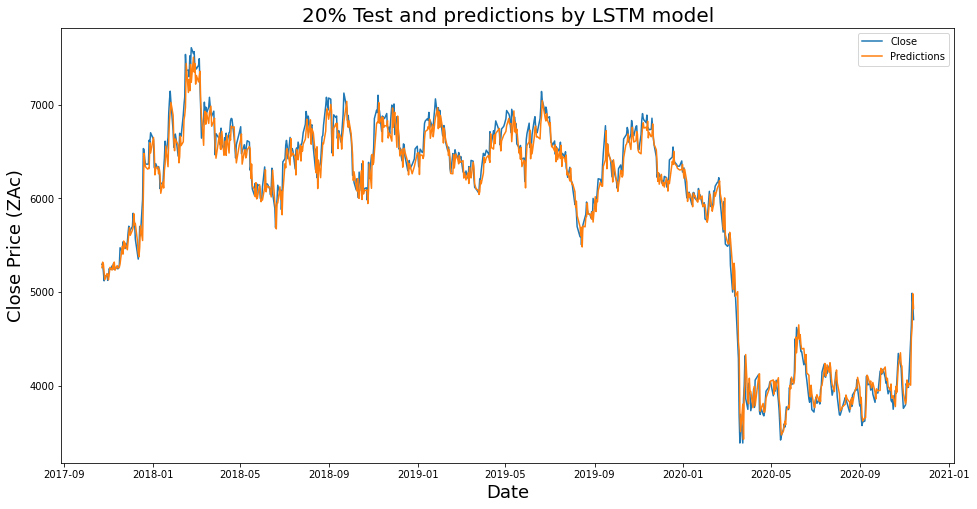

In [47]:
#Plot the data
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = focast

#Visualioze the data
plt.figure(figsize=(16,8))
plt.title('20% Test and predictions by LSTM model', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (ZAc)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Close','Predictions'],loc='upper right')
plt.show()

**4.4 Print the close and Predictions by LSTM**

In [48]:
#We can print the predicted values alongside the original closing price
valid[['Close','Predictions']]

,Close,Predictions
Date,,
2017-10-23,5297.0,5260.866699
2017-10-24,5298.0,5319.410156
2017-10-25,5220.0,5302.389648
2017-10-26,5120.0,5221.747070
2017-10-27,5166.0,5132.387695
...,...,...
2020-11-09,4475.0,4007.050537
2020-11-10,4644.0,4511.687988
2020-11-11,4988.0,4618.730469


**4.5 Print out the metrics**

In [50]:
#We ae going to print results of the two models using metrics 
#Get the root mean square error (RMSE)
#To check how best the model perfom 

################     LSTM     #################
#p=np.sqrt(np.mean(predictions-y_test)**2)
ppp=rmse(y_test,focast)
print('RMSE for LSTM: '+str(ppp))
mape = np.mean(np.abs(focast - y_test)/np.abs(y_test))*100
print('MAPE for LSTM: '+str(mape)+ ' %')

RMSE for LSTM: [143.37231265]
MAPE for LSTM: 1.9325366350099098 %
